# General notes
It will be useful to store a dictionary for both:
* piece type -> coords

piece_dict = {

    "upper": {"p": [coords,], "s": [coords,], "r": [coords,]},
    "lower": {"p": [coords,], "s": [coords,], "r": [coords,]},
    "block": [coords,]
}


* coord -> pieces

coord_dict = {\
\
&emsp;(0,0): [piece_1, piece_2, ...],\
&emsp;(0,1): [piece_1, piece_2, ...],\
&emsp;.\
&emsp;.\
&emsp;.\
}

where each piece is represented by one of the following: "R", "P", "S", "r", "p", "s" for upper and lower respectively\
eg:\
&emsp;(0,0): [p, P] , a lower paper and upper paper both sitting at (0,0)

For each state we will need to store the moves which each piece makes: move_type, (from coord), (to coord)


# Functions

#### validMove(piece_team, move_type, from_pos, to_pos, coord_dict)
* piece_team is either "upper" or "lower"
* move_type is either "SLIDE" or "SWING"
* from_pos is the coordinate of where the piece is now
* to_pos is the coordinate of the desired location
* coord_dict represents the board state

a SLIDE move is valid if:
* the inital position is not outside the board
* there is an upper piece in the initial position
* final position is not outside the board
* there is not a block in the final position


a SWING move is valid if:
* the inital position is not outside the board
* there is an upper piece in the initial position
* final position is not outside the board
* there is not a block in the final position
* the final position is not adjacent to the initial position
* another upper piece is both adjacent to the starting position and final position

#### getValidMovesForPiece(from_pos, coord_dict, piece_team, thrown_pieces_num)
* from_pos is the coordinate of the piece to get valid moves for
* coord_dict is the board representation
* piece_team is either "upper" or "lower"
* thrown_pieces_num is how many pieces the team has thrown



In order to get all the valid moves for a given position:
* Make sure the initial position has an upper piece (else return empty list)
* Need to check all 6 adjacent positions to get all the valid SLIDE moves
* Need to check all 12 positions 2 tiles away to get all the valid SWING moves

Iterate over all the positions to check and pass them into the validMove function, if a move is valid, append the move to a list of valid moves

valid moves will be of the form:\
**[move_type, (initial_x, inital_y), (final_x, final_y)]**

eg:

**["SLIDE", (0, 0), (1,-1)]**

#### getThrowMoves(thrown_num, team)
* throw_num is how many throws team has made
* team is "upper" or "lower"

* returns all possible throws for upper and lower in the form:
    * upper_throws, lower_throws


#### resolveMoves(upper_move, lower_move, coord_dict, upper_thrown_num, lower_thrown_num)
* upper_move is upper's move
* lower_move is lower's move
* coord_dict is a dictionary of (x,y): [piece_1, piece_2, ...] pairs for all tiles that have pieces on them (upper and lower), where each piece is represented by one of the following: "R", "P", "S", "r", "p", "s" for upper and lower respectively
* upper_throw_num is how many throws upper has made
* lower_throw_num is how many throws upper has made

resolveMoves takes in the current board, applies both moves, then updates the board
* For each coordinate, the following rules are applied:
    * If the hex is occupied by one or more tokens with each symbol, all of the tokens are defeated.
    * If the hex is occupied by a Rock token, all Scissors tokens there are defeated.
    * If the hex is occupied by a Scissors token, all Paper tokens there are defeated.
    * If the hex is occupied by a Paper token, all Rock tokens there are defeated.
* The output of the function is a new coord_dict, piece_dict, upper_thrown_num and lower_thrown_num
 
#### deepCopy(list_dict)
* Takes in a dictionary where values are a list and returns a new dictionary with everything copied (no longer pointing to same memory addresses)

#### getEmptyBoardConfigs()
* Returns an empty coord_dict and piece_dict representation of the board

#### convertFromBoardConfig(board_config)
* board_config is the json text representation from part A (and the online board maker)
* returns a coord_dict and piece_dict representation

#### hasInvincibleToken(piece_dict, upper_thrown_num, lower_thrown_num)
* state_node holds all information about the current board state
* the function returns two boolean values:
    * if upper has at least 1 invincible piece
    * if lower has at least 1 invincible piece
* in the form: upper_bool, lower_bool

#### gameEnded(piece_dict, upper_thrown_num, lower_thrown_num, turn_num)
* state_node holds all information about the current board state
* function checks all ending conditions (except #4) and returns one of the following values:
    * UPPER_WINS = 1
    * LOWER_WINS = -1
    * DRAW = 2
    * NOT_ENDED = 0
    
#### getPossibleMoves(state_node, team)
* state_node holds all information about the current board state
* function collects all moves possible for each piece on the board as well as all throw moves for both upper and lower and returns them as such:
    * all_possible_moves

#### buildStateTree(state_node, desired_depth, pruning_function)
* state_node holds all information about the current board state
* desired_depth is how many moves deep you want to generate the tree
* pruning_function is a function which you specify which takes in: state_node, all_upper_moves, all_lower_moves and returns a list of approved upper moves and a list of approved lower moves as such:
    * upper_moves, lower_moves
    
function takes in an initial state_node holding all the relevant board information, then generates all the moves to be explored for both upper and lower, then creates child nodes representing the resulting moves and the resulting state of the board in a new state_node.

This process continues for each path until a path reaches the desired depth, or it reaches the end of the game

#### calculateMoveScores(state_node, heuristic_function)
* state_node holds all information about the current board state
* heuristic_function is a specified function which takes in a state_node and returns a value representing how favourable the state is.

function explores the tree down the the leaf nodes, then applies the heuristic to only the leaf nodes, then propogates the scores up the tree, taking averages until the averages are passed into the moves which we make next, thereby quantifying how favourable each one of our potential moves are.

#### getLeafStates(state_node)
* state_node holds all information about the current board state

function returns a list of all the leaf state_nodes

#### print_move_scores(state_node)
* state_node holds all information about the current board state

function prints out all of our next possible moves along with their average heuristic values


# Classes

#### State_node
Stores:
* team        
* coord_dict
* piece_dict
* upper_thrown_num
* lower_thrown_num
* primary_move_list
* parent_secondary_node
* node_depth


#### Primary_move_node
Stores:
* move
* secondary_move_list
* parent_state
* score_sum
* average_score

#### Secondary_move_node
Stores:
* move
* state_node
* parent_move

In [101]:
from IPython.display import clear_output
from collections import defaultdict as dd
from itertools import product
from main import print_board
import numpy as np
import random
import time
import math
import json

In [40]:
# Directions for tiles a distance of 1 away
ONE_TILE_DIRECTIONS = ((-1, 0), (-1,1), (0,-1), (0,1), (1,-1), (1,0))

# Directions for tiles a distance of 2 away
TWO_TILE_DIRECTIONS = ((-2, 0), (-2,2), (0,-2), (0,2), (2,-2), (2,0),
                       (2,-1), (1,1), (-1,2), (-2,1), (-1,-1), (1,-2))

UPPER_WINS = 1
LOWER_WINS = -1
DRAW = 2
NOT_ENDED = 0


def tuple_addition(tuple1, tuple2):
    return tuple(map(lambda i, j: i + j, tuple1, tuple2))

def outOfBounds(pos):
    # Returns true if position given is out of bounds
    x = pos[0]
    y = pos[1]
    return (abs(-x - y) > 4) or (abs(x) > 4 or abs(y) > 4)

def validMove(piece_team, move_type, from_pos, to_pos, coord_dict):

    # Need to add throw move functionality
    # Need to have #throws_had as input

    # piece_team specifies if you are playing as "upper" or "lower"

    # Check if starting or finishing positions is out of bounds
    if outOfBounds(from_pos) or outOfBounds(to_pos):
        return False

    # Check that there is anything in from_pos
    if not from_pos in coord_dict:
        return False

    if piece_team == "upper":
        # Check that there is an upper piece in from_pos
        if not ("R" in coord_dict[from_pos] or "P" in coord_dict[from_pos] or "S" in coord_dict[from_pos]):
            return False
    elif piece_team == "lower":
        if not ("r" in coord_dict[from_pos] or "p" in coord_dict[from_pos] or "s" in coord_dict[from_pos]):
            return False

    adjacent_tiles = [tuple_addition(i, from_pos) for i in ONE_TILE_DIRECTIONS]

    if move_type == "SLIDE":

        if to_pos in adjacent_tiles:
            return True
        else:
            return False

    elif move_type == "SWING":

        # Check if from_pos is adjacent to to_pos, if it is, the move is invalid
        if to_pos in adjacent_tiles:
            # It is adjacent
            return False

        # Look at all tiles one distance away from from_pos
        for adjacent_tile in adjacent_tiles:
            # Check if adjacent tile is adjacent to to_pos
            # If there is also an upper in that position then the move is valid


            if to_pos in [tuple_addition(i, adjacent_tile) for i in ONE_TILE_DIRECTIONS]:
                # The current adjacent_tile is adjacent to both from_pos and to_pos

                # Check that there is a friendly piece to swing around
                if piece_team == "upper":
                    if adjacent_tile in coord_dict and ("R" in coord_dict[adjacent_tile] or "P" in coord_dict[adjacent_tile] or "S" in coord_dict[adjacent_tile]):
                        # There is an upper piece adjacent to both from_pos and to_pos
                        return True
                if piece_team == "lower":
                    if adjacent_tile in coord_dict and ("r" in coord_dict[adjacent_tile] or "p" in coord_dict[adjacent_tile] or "s" in coord_dict[adjacent_tile]):
                        # There is a lower piece adjacent to both from_pos and to_pos
                        return True

        # If all adjacent upper pieces have been checked and none of them are adjacent to to_pos
        # then the move is invalid
        return False

    else:
        raise ValueError('move_type is invalid! It must only be "SLIDE" or "SWING"')


def getEmptyBoardConfigs():
    piece_dict = {"upper": {"r": [], "p": [], "s": []},
                  "lower": {"r": [], "p": [], "s": []}}

    coord_dict = dd(list)

    return coord_dict, piece_dict


#########   NOT NEEDED ANYMORE, BUT USEFUL FOR TESTING   #########

def convertFromBoardConfig(board_config):
    # board_config is the json text

    board_config_dict = json.loads(board_config)

    coord_dict = dd(list)

    piece_dict = {"upper": {"r": [], "p": [], "s": []},
                  "lower": {"r": [], "p": [], "s": []},
                  "block": []}

    for piece_team, piece_list in board_config_dict.items():

        for piece in piece_list:

            if piece_team == "upper":
                coord_dict[tuple(piece[1:])].append(piece[0].upper())

                piece_dict[piece_team][piece[0]].append(tuple(piece[1:]))

            elif piece_team == "lower":
                coord_dict[tuple(piece[1:])].append(piece[0].lower())

                piece_dict[piece_team][piece[0]].append(tuple(piece[1:]))

            elif piece_team == "block":
                coord_dict[tuple(piece[1:])].append("b")

                piece_dict[piece_team].append(tuple(piece[1:]))


            else:
                raise ValueError('board_config is invalid! piece keys can only be "upper", "lower" or "block"')

    return coord_dict, piece_dict


##################################################################


# Need to know how many throws have been had to get valid throws
# and if we are calculating for lower or upper (to know which side)
def getValidMovesForPiece(from_pos, coord_dict, piece_team):

    # piece_team is either "upper" or "lower"
    # piece_type is one of: "r", "p", "s"

    # Need throw moves

    valid_moves = []

    # First check the 6 possible SLIDE moves

    adjacent_tiles = [tuple_addition(i, from_pos) for i in ONE_TILE_DIRECTIONS]

    for adjacent_tile in adjacent_tiles:
        if validMove(piece_team, "SLIDE", from_pos, adjacent_tile, coord_dict):
            valid_moves.append(("SLIDE", from_pos, adjacent_tile))

    # Secondly check the 12 SWING moves

    two_tiles_away = [tuple_addition(i, from_pos) for i in TWO_TILE_DIRECTIONS]

    for tile in two_tiles_away:
        if validMove(piece_team, "SWING", from_pos, tile, coord_dict):
            valid_moves.append(("SWING", from_pos, tile))

    return valid_moves


def getThrowMoves(thrown_num, team):
    
    ROW_COORDS = [[(4, -4), (4, -3), (4, -2), (4, -1), (4, 0)],
                  [(3, -4), (3, -3), (3, -2), (3, -1), (3, 0), (3, 1)],
                  [(2, -4), (2, -3), (2, -2), (2, -1), (2, 0), (2, 1), (2, 2)],
                  [(1, -4), (1, -3), (1, -2), (1, -1), (1, 0), (1, 1), (1, 2), (1, 3)],
                  [(0, -4), (0, -3), (0, -2), (0, -1), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
                  [(-1, -3), (-1, -2), (-1, -1), (-1, 0), (-1, 1), (-1, 2), (-1, 3), (-1, 4)],
                  [(-2, -2), (-2, -1), (-2, 0), (-2, 1), (-2, 2), (-2, 3), (-2, 4)],
                  [(-3, -1), (-3, 0), (-3, 1), (-3, 2), (-3, 3), (-3, 4)],
                  [(-4, 0), (-4, 1), (-4, 2), (-4, 3), (-4, 4)]]

    throws = []

    if team == "upper":
        if thrown_num < 9:
            for row_index in range(thrown_num+1):
                for coord in ROW_COORDS[row_index]:
                    throws += [("THROW", "r", coord), ("THROW", "p", coord), ("THROW", "s", coord)]
    else:
        # Deal with lower throws
        if thrown_num < 9:
            for row_index in range(8 - thrown_num, 9):
                for coord in ROW_COORDS[row_index]:
                    throws += [("THROW", "r", coord), ("THROW", "p", coord), ("THROW", "s", coord)]

    return throws
                
def resolveMoves(upper_move, lower_move, coord_dict, upper_thrown_num, lower_thrown_num):
    # Given list of moves (one for each upper piece) and coord_dict
    # Create new coord_dict, where the pieces are deleted from each from_pos and added to each to_pos
    # Go through each to_pos key in coord_dict and apply the rules
    # Create a new piece_dict, including the pieces that are still alive

    # return new coord_dict and piece_dict

    new_coord_dict = deepCopy(coord_dict)

    new_piece_dict = {"upper": {"r": [], "p": [], "s": []},
                      "lower": {"r": [], "p": [], "s": []}}

    # Deal with upper 
    move_type_upper = upper_move[0]
    
    if move_type_upper in ["SLIDE", "SWING"]:

        from_pos = upper_move[1]
        to_pos = upper_move[2]

        # Looking at the first element of the list for position (from_pos), it could be a LOWER piece, but it must be
        # the same type as the UPPER which is at the same position

        piece_type = new_coord_dict[from_pos][0].upper()

        new_coord_dict[from_pos].remove(piece_type)

        # Check if that tile is empty now

        if new_coord_dict[from_pos] == []:
            del new_coord_dict[from_pos]

        # Add the same type of piece to the to_coord

        new_coord_dict[to_pos].append(piece_type)
        
    else:
        # This is a THROW, just need to add the piece to the new coord dict
        to_pos = upper_move[2]
        piece_type = upper_move[1].upper()
        new_coord_dict[to_pos].append(piece_type)


    # Deal with lower 
    move_type_lower = lower_move[0]
    
    if move_type_lower in ["SLIDE", "SWING"]:

        from_pos = lower_move[1]
        to_pos = lower_move[2]

        # Looking at the first element of the list for position (from_pos), it could be an UPPER piece, but it must be
        # the same type as the LOWER which is at the same position

        piece_type = new_coord_dict[from_pos][0].lower()

        new_coord_dict[from_pos].remove(piece_type)

        # Check if that tile is empty now

        if new_coord_dict[from_pos] == []:
            del new_coord_dict[from_pos]

        # Add the same type of piece to the to_coord

        new_coord_dict[to_pos].append(piece_type)
        
    else:
        # This is a THROW, just need to add the piece to the new coord dict
        to_pos = lower_move[2]
        piece_type = lower_move[1].lower()
        new_coord_dict[to_pos].append(piece_type)


    # Go through each to_coord and remove pieces according to the rules

    # Rules:
        # If the hex is occupied by one or more tokens with each symbol, all of the tokens are defeated.
        # If the hex is occupied by a Rock token, all Scissors tokens there are defeated.
        # If the hex is occupied by a Scissors token, all Paper tokens there are defeated.
        # If the hex is occupied by a Paper token, all Rock tokens there are defeated.

    for move in list(set([upper_move, lower_move])):

        to_pos = move[-1]

        pieces = new_coord_dict[to_pos]

        rock_present = ("R" in pieces or "r" in pieces)
        paper_present = ("P" in pieces or "p" in pieces)
        scissors_present = ("S" in pieces or "s" in pieces)

        if rock_present and paper_present and scissors_present:
            del new_coord_dict[to_pos]

        elif rock_present and scissors_present:
            new_coord_dict[to_pos] = [piece for piece in pieces if piece not in ["S", "s"]]

        elif scissors_present and paper_present:
            new_coord_dict[to_pos] = [piece for piece in pieces if piece not in ["P", "p"]]

        elif paper_present and rock_present:
            new_coord_dict[to_pos] = [piece for piece in pieces if piece not in ["R", "r"]]

    # Create new_piece_dict from new_coord_dict:

    for coord, pieces in new_coord_dict.items():
        for piece in pieces:

            if piece in ["R", "P", "S"]:
                new_piece_dict["upper"][piece.lower()].append(coord)

            elif piece in ["r", "p", "s"]:
                new_piece_dict["lower"][piece.lower()].append(coord)
            else:
                raise ValueError('piece value of:', piece, 'is not upper or lower!')

    new_upper_thrown_num = upper_thrown_num
    new_lower_thrown_num = lower_thrown_num
    
    if move_type_upper == "THROW":
        new_upper_thrown_num += 1
    if move_type_lower == "THROW":
        new_lower_thrown_num += 1 
    
    return new_coord_dict, new_piece_dict, new_upper_thrown_num, new_lower_thrown_num


def deepCopy(list_dict):

    copy = dd(list)

    for key, value in list_dict.items():
        copy[key] = value.copy()

    return copy

def hasInvincibleToken(piece_dict, upper_thrown_num, lower_thrown_num):
    # Key loses to value
    lose_dict = {"r": "p", "p": "s", "s": "r"}
    
    upper_invincible = False
    lower_invincible = False
    
    upper_invincible_type = None
    lower_invincible_type = None
    
    # Checking if upper has an invincible token
    if lower_thrown_num == 9:
        if piece_dict["upper"]["r"] != [] and piece_dict["lower"]["p"] == []:
            upper_invincible = True
            upper_invincible_type = "r"
        elif piece_dict["upper"]["p"] != [] and piece_dict["lower"]["s"] == []:
            upper_invincible = True
            upper_invincible_type = "p"
        elif piece_dict["upper"]["s"] != [] and piece_dict["lower"]["r"] == []:
            upper_invincible = True
            upper_invincible_type = "s"
        else:
            upper_invincible = False
            
    # Checking if lower has an invincible token
    if upper_thrown_num == 9:
        if piece_dict["lower"]["r"] != [] and piece_dict["upper"]["p"] == []:
            lower_invincible = True
            lower_invincible_type = "r"
        elif piece_dict["lower"]["p"] != [] and piece_dict["upper"]["s"] == []:
            lower_invincible = True
            lower_invincible_type = "p"
        elif piece_dict["lower"]["s"] != [] and piece_dict["upper"]["r"] == []:
            lower_invincible = True
            lower_invincible_type = "s"
        else:
            lower_invincible = False
    
    return upper_invincible, lower_invincible, upper_invincible_type, lower_invincible_type
    

def gameEnded(piece_dict, upper_thrown_num, lower_thrown_num, turn_num, debug=False):
    
    # UPPER_WINS = 1
    # LOWER_WINS = -1
    # DRAW = 2
    # NOT_ENDED = 0
    
    # Condition 1
    if lower_thrown_num == 9 and (
        piece_dict["lower"]["r"] == [] and piece_dict["lower"]["p"] == [] and piece_dict["lower"]["s"] == []):
        
        if upper_thrown_num < 9 or not (
        piece_dict["upper"]["r"] == [] and piece_dict["upper"]["p"] == [] and piece_dict["upper"]["s"] == []):
            if debug: print("Condition 1: upper wins")
            if debug: print(piece_dict)
            return UPPER_WINS
        else:
            if debug: print("Condition 1: draw")
            if debug: print(piece_dict)
            return DRAW
    elif upper_thrown_num == 9 and (
        piece_dict["upper"]["r"] == [] and piece_dict["upper"]["p"] == [] and piece_dict["upper"]["s"] == []):
        
        if lower_thrown_num < 9 or not (
        piece_dict["lower"]["r"] == [] and piece_dict["lower"]["p"] == [] and piece_dict["lower"]["s"] == []):
            if debug: print("Condition 1: lower wins")
            if debug: print(piece_dict)
            return LOWER_WINS
        else:
            if debug: print("Condition 1: draw")
            if debug: print(piece_dict)
            return DRAW
    
    # Condition 2
    elif hasInvincibleToken(piece_dict, upper_thrown_num, lower_thrown_num)[:2] == (True, True):
        if debug: print("Condition 2: draw")
        if debug: print(piece_dict)
        return DRAW
    
    # Condition 3
    elif hasInvincibleToken(piece_dict, upper_thrown_num, lower_thrown_num)[:2] == (True, False) and (
        len(piece_dict["lower"]["r"]) + len(piece_dict["lower"]["p"]) + len(piece_dict["lower"]["s"]) == 1):
        if debug: print("Condition 3: upper wins")
        if debug: print(piece_dict)
        return UPPER_WINS
    elif hasInvincibleToken(piece_dict, upper_thrown_num, lower_thrown_num)[:2] == (False, True) and (
        len(piece_dict["upper"]["r"]) + len(piece_dict["upper"]["p"]) + len(piece_dict["upper"]["s"]) == 1):
        if debug: print("Condition 3: lower wins")
        return LOWER_WINS
    
    # Condition 4   *** IMPLEMENT LATER, QUITE ANNOYING ***
    
    # Condition 5
    elif turn_num >= 360:
        if debug: print("Condition 5: draw")
        if debug: print(piece_dict)
        return DRAW
    
    else:
        if debug: print("Not ended yet")
        if debug: print(piece_dict)
        return NOT_ENDED


def manhattanDistance(c0, c1):
    dx = c1[0] - c0[0]
    dy = c1[1] - c0[1]

    if np.sign(dx) == np.sign(dy):
        return abs(dx + dy)
    else:
        return max(abs(dx), abs(dy))

###########################################################################################
#                                        CLASSES                                          #

class State_node:
        def __init__(self, team, coord_dict, piece_dict, upper_thrown_num, lower_thrown_num, primary_move_list, 
                     parent_secondary_node, node_depth):
            
            self.team = team
            
            self.coord_dict = coord_dict
            self.piece_dict = piece_dict
            
            self.upper_thrown_num = upper_thrown_num
            self.lower_thrown_num = lower_thrown_num
            
            self.primary_move_list = primary_move_list
            
            self.parent_secondary_node = parent_secondary_node
            
            self.node_depth = node_depth
        
        
class Primary_move_node:
        def __init__(self, move, secondary_move_list, parent_state):
            
            self.move = move
            self.secondary_move_list = secondary_move_list
            self.parent_state = parent_state
            
            self.score_sum = 0
            self.average_score = 0

        # Compare nodes
        def __eq__(self, other):
            return self.average_score == other.average_score

        # Sort nodes
        def __lt__(self, other):
             return self.average_score < other.average_score
        
        
class Secondary_move_node:
        def __init__(self, move, state_node, parent_move):
            
            self.move = move
            self.state_node = state_node
            self.parent_move = parent_move


def getPossibleMoves(state_node, team, include_throws=True):

    coord_dict = state_node.coord_dict
    piece_dict = state_node.piece_dict
    
    all_possible_moves = []
    
    if team == "upper":
        upper_thrown_num = state_node.upper_thrown_num

        if include_throws:
            # Get throw moves
            upper_throw_moves = getThrowMoves(upper_thrown_num, team)

            all_possible_moves += upper_throw_moves

        # Get all possible moves for upper pieces on the board
        for piece, coordinates in piece_dict["upper"].items():

            for coordinate in coordinates:

                possible_moves = getValidMovesForPiece(coordinate, coord_dict, "upper")

                all_possible_moves += possible_moves
    else:
        lower_thrown_num = state_node.lower_thrown_num

        if include_throws:
            # Get throw moves
            lower_throw_moves = getThrowMoves(lower_thrown_num, team)

            all_possible_moves += lower_throw_moves

        # Get all possible moves for lower pieces on the board
        for piece, coordinates in piece_dict["lower"].items():

            for coordinate in coordinates:

                possible_moves = getValidMovesForPiece(coordinate, coord_dict, "lower")

                all_possible_moves += possible_moves
    
    return all_possible_moves
    
            
def buildStateTree(state_node, desired_depth, pruning_function, turn_num):
    
    team = state_node.team
    coord_dict = state_node.coord_dict
    piece_dict = state_node.piece_dict
    upper_thrown_num = state_node.upper_thrown_num
    lower_thrown_num = state_node.lower_thrown_num
    parent_depth = state_node.node_depth
    
    
    #all_possible_moves_upper, all_possible_moves_lower = getPossibleMoves(state_node)
    
    # Do pruning
    #moves_upper, moves_lower = pruning_function(state_node, all_possible_moves_upper, all_possible_moves_lower)
    
    moves_upper, moves_lower = pruning_function(state_node)
    
    if team == "lower":
        for lower_move in moves_lower:
            
            secondary_move_list = []                                                    
            new_primary_move_node = Primary_move_node(lower_move, secondary_move_list, state_node)
            

            state_node.primary_move_list.append(new_primary_move_node)
            
            for upper_move in moves_upper:
                
                new_coord_dict, new_piece_dict, new_upper_thrown_num, new_lower_thrown_num = resolveMoves(
                    upper_move, lower_move, coord_dict, upper_thrown_num, lower_thrown_num)
                
                new_secondary_move_node = Secondary_move_node(upper_move, None, new_primary_move_node)
                
                new_primary_move_node.secondary_move_list.append(new_secondary_move_node)
                
                # Create new state node
                
                #Calculating new node depth
                
                new_node_depth = parent_depth + 1
                
                new_turn_num = turn_num + 1
                
                new_state_node = State_node(
                    team, new_coord_dict, new_piece_dict, new_upper_thrown_num, new_lower_thrown_num, 
                    [], new_secondary_move_node, new_node_depth)
    
                new_secondary_move_node.state_node = new_state_node
        
                if new_node_depth < desired_depth:
                    # Check to see if game has ended (if so don't expand)
                    if not gameEnded(new_piece_dict, new_upper_thrown_num, new_lower_thrown_num, new_node_depth):
                        buildStateTree(new_state_node, desired_depth, pruning_function=pruning_function, turn_num=new_turn_num)
    # team is upper                      
    else:
        for upper_move in moves_upper:
            
            secondary_move_list = []                                                       
            new_primary_move_node = Primary_move_node(upper_move, secondary_move_list, state_node)
            

            state_node.primary_move_list.append(new_primary_move_node)
            
            for lower_move in moves_lower:
                
                new_coord_dict, new_piece_dict, new_upper_thrown_num, new_lower_thrown_num = resolveMoves(
                    upper_move, lower_move, coord_dict, upper_thrown_num, lower_thrown_num)
                
                new_secondary_move_node = Secondary_move_node(lower_move, None, new_primary_move_node)
                
                new_primary_move_node.secondary_move_list.append(new_secondary_move_node)
                
                # Create new state node
                
                #Calculating new node depth
                
                new_node_depth = parent_depth + 1
                
                new_turn_num = turn_num + 1
                
                new_state_node = State_node(
                    team, new_coord_dict, new_piece_dict, new_upper_thrown_num, new_lower_thrown_num, 
                    [], new_secondary_move_node, new_node_depth)
    
                new_secondary_move_node.state_node = new_state_node
        
                if new_node_depth < desired_depth:
                    # Check to see if game has ended (if so don't expand)
                    if not gameEnded(new_piece_dict, new_upper_thrown_num, new_lower_thrown_num, new_node_depth):
                        buildStateTree(new_state_node, desired_depth, pruning_function=pruning_function, turn_num=new_turn_num)

def getLeafStates(state_node):
    
    if state_node.primary_move_list == []:
        # This is a leaf state node
        return [state_node]
    
    leaf_nodes = []
    
    for primary_move in state_node.primary_move_list:
        for secondary_move in primary_move.secondary_move_list:
            leaf_nodes += getLeafStates(secondary_move.state_node)
            
    return leaf_nodes

def calculateMoveScores(state_node, heuristic_function):
    # When this has been called, the tree has been built to the specified depth
    # Need to go down to the leaf primary_move_nodes, then look at each state_node below them,
    # if the state_node has no primary_move_nodes in its primary_move_list, then it is a
    # leaf node. As it is a leaf node, you can run that state through the heuristic function
    # Add the heuristic value to the "sum_scores" variable in the primary_move_node.
    
    # If the state_node below is not a leaf node, then call calculateMoveScores with that
    # state_node as input
    
    if state_node.primary_move_list == []:
        # This state is a leaf state
        
        heuristic_value = heuristic_function(state_node)
        
        # Add this heuristic value to the parent primary_mode_node
        
        state_node.parent_secondary_node.parent_move.score_sum += heuristic_value
        
    else:
        
        for primary_move in state_node.primary_move_list:
            
            for secondary_move in primary_move.secondary_move_list:
                
                calculateMoveScores(secondary_move.state_node, heuristic_function)
                
            # All heuristic values now calculated for current primary_move
            # Can now calculate the average for this primary_move and then add it
            # To the primary move above
            

            
            primary_move.average_score = primary_move.score_sum / len(primary_move.secondary_move_list)
            
            if state_node.parent_secondary_node != None:
                state_node.parent_secondary_node.parent_move.score_sum += primary_move.average_score / len(state_node.primary_move_list)


def getBestMove(state_node, higher_score_is_better=True, randomly_choose_tie=True):
    
    current_best_moves = []
    
    
    if higher_score_is_better:
    
        highest_score = -1000

        for primary_move in state_node.primary_move_list:
            if primary_move.average_score > highest_score:

                current_best_moves = [primary_move.move]

                highest_score = primary_move.average_score

            elif primary_move.average_score == highest_score:
                current_best_moves.append(primary_move.move)
                
    else:
        
        lowest_score = 1000

        for primary_move in state_node.primary_move_list:
            if primary_move.average_score < lowest_score:

                current_best_moves = [primary_move.move]

                lowest_score = primary_move.average_score

            elif primary_move.average_score == lowest_score:
                current_best_moves.append(primary_move.move)
                
    # current_best_moves now stores a list of the best moves (potentially multiple)
    
    if randomly_choose_tie:
        if len(current_best_moves) > 1:
            random.shuffle(current_best_moves)

    return current_best_moves[0]
        
        
def print_move_scores(state_node):
    # This function is used after calculateMoveScores to
    # print out all the possible next moves and their scores

    print("******** Move scores: ********\n")

    for primary_move in sorted(state_node.primary_move_list):
        print(primary_move.move)
        print("Average score: {}\n".format(primary_move.average_score))
        
    print("******************************")

These are heuristics for evaluating the board:

In [3]:
# Gives ratio of player pieces to enemy pieces only on board
def board_ratio(team, piece_dict) -> float:
    if team == "upper":
        teamcount = 0
        for piece in piece_dict["upper"]:
            teamcount += len(piece_dict["upper"][piece])
        enemycount = 0
        for piece in piece_dict["lower"]:
            enemycount += len(piece_dict["lower"][piece])
    # If team is not upper, team is lower
    else:
        teamcount = 0
        for piece in piece_dict["lower"]:
            teamcount += len(piece_dict["lower"][piece])
        enemycount = 0
        for piece in piece_dict["upper"]:
            enemycount += len(piece_dict["upper"][piece])
    return (teamcount/enemycount)

# Gives ratio of player pieces to enemy pieces on board and left to throw
def board_throw_ratio(throws_upper, throws_lower, team, piece_dict) -> float:
    # Get the number of pieces for upper and lower
    # Get number of pieces left to throw
    upper_count = (9 - throws_upper)
    lower_count = (9 - throws_lower)
    # Get number of pieces on the board
    for piece in piece_dict["upper"]:
        upper_count += len(piece_dict["upper"][piece])
    for piece in piece_dict["lower"]:
        lower_count += len(piece_dict["lower"][piece])
    # Prevent divide by 0, enemy on 0 pieces is worth twice as much as enemy on 1 piece
    if upper_count == 0:
        upper_count = 0.5
    if lower_count == 0:
        lower_count = 0.5
    # get ratio
    if team == "upper":
        ratio = upper_count/lower_count
    else:
        ratio = lower_count/upper_count
    return ratio


#def board_throw_ratio(throws_upper, throws_lower, team, piece_dict) -> float:
#    if team == "upper":
#        teamcount = (9 - throws_upper)
#        for piece in piece_dict["upper"]:
#            teamcount += len(piece_dict["upper"][piece])
#        enemycount = (9 - throws_lower)
#        for piece in piece_dict["lower"]:
#            enemycount += len(piece_dict["lower"][piece])
#    # If team is not upper, team is lower
#    else:
#        teamcount = (9 - throws_lower)
#        for piece in piece_dict["lower"]:
#            teamcount += len(piece_dict["lower"][piece])
#        enemycount = (9 - throws_upper)
#        for piece in piece_dict["upper"]:
#            enemycount += len(piece_dict["upper"][piece])
#    return (teamcount/enemycount)

# Gives absolute number of enemy pieces captured
def enemy_pieces_captured(enemy_throws, team, piece_dict) -> float:
    if team == "upper":
        captured = enemy_throws
        for piece in piece_dict["lower"]:
            captured -= len(piece_dict["lower"][piece])
    # If team is not upper, team is lower
    else:
        captured = enemy_throws
        for piece in piece_dict["upper"]:
            captured -= len(piece_dict["upper"][piece])
    return captured

# Gives number of pieces with "prey" within 2 or less tiles
def get_proximty_prey(team, piece_dict):
    score = 0
    if team == "upper":
        for piece in piece_dict["upper"]:
            # Get the prey type
            if piece == "r":
                prey = "s"
            elif piece == "p":
                prey = "r"
            else:
                prey = "p"
            for coords in piece_dict["upper"][piece]:
                for preycoords in piece_dict["lower"][prey]:
                    if manhattanDistance(coords, preycoords) <= 2:
                        score += 1
    # If team is not upper, team is lower
    else:
        for piece in piece_dict["lower"]:
            # Get the prey type
            if piece == "r":
                prey = "s"
            elif piece == "p":
                prey = "r"
            else:
                prey = "p"
            for coords in piece_dict["lower"][piece]:
                for preycoords in piece_dict["upper"][prey]:
                    if manhattanDistance(coords, preycoords) <= 2:
                        score += 1
    return score

# Gives score based on proximity to prey, adjacent worth 2 and 2 tiles away worth 1
def get_proximty_prey_score(team, piece_dict):
    score = 0
    if team == "upper":
        for piece in piece_dict["upper"]:
            # Get the prey type
            if piece == "r":
                prey = "s"
            elif piece == "p":
                prey = "r"
            else:
                prey = "p"
            for coords in piece_dict["upper"][piece]:
                for preycoords in piece_dict["lower"][prey]:
                    score += max(3 - manhattanDistance(coords, preycoords), 0)
    # If team is not upper, team is lower
    else:
        for piece in piece_dict["lower"]:
            # Get the prey type
            if piece == "r":
                prey = "s"
            elif piece == "p":
                prey = "r"
            else:
                prey = "p"
            for coords in piece_dict["lower"][piece]:
                for preycoords in piece_dict["upper"][prey]:
                    score += max(3 - manhattanDistance(coords, preycoords), 0)
    return score

These are pruning functions for throw actions:

In [4]:
def get_throws_furthest_row(throws, team) -> list:
    # Calculate furthest row we can throw to
    # 5th row is 0, upper counts down, lower counts up
    if team == "upper":
        row = 4 - throws
    else:
        row = throws - 4
    # Now get the tuples of each tile in the row
    tiles = []
    if row == -4:
        tiles.extend([(-4, 4), (-4, 3), (-4, 2), (-4, 1), (-4, 0)])
    elif row == -3:
        tiles.extend([(-3, 4), (-3, 3), (-3, 2), (-3, -1), (-3, 0), (-3, 1)])
    elif row == -2:
        tiles.extend([(-2, 4), (-2, 3), (-2, 2), (-2, 1), (-2, 0), (-2, -1), (-2, -2)])
    elif row == -1:
        tiles.extend([(-1, 4), (-1, 3), (-1, 2), (-1, 1), (-1, 0), (-1, -1), (-1, -2), (-1, -3)])
    elif row == 0:
        tiles.extend([(0, 4), (0, 3), (0, 2), (0, 1), (0, 0), (0, -1), (0, -2), (0, -3), (0, -4)])
    elif row == 1:
        tiles.extend([(1, 3), (1, 2), (1, 1), (1, 0), (1, -1), (1, -2), (1, -3), (1, -4)])
    elif row == 2:
        tiles.extend([(2, 2), (2, 1), (2, 0), (2, -1), (2, -2), (2, -3), (2, -4)])
    elif row == 3:
        tiles.extend([(3, 1), (3, 0), (3, -1), (3, -2), (3, -3), (3, -4)])
    elif row == 4:
        tiles.extend([(4, 0), (4, -1), (4, -2), (4, -3), (4, -4)])
    # Now get the tuples of each tile in the row
    pieces = ["r", "p", "s"]
    moves = []
    for piece in pieces:
        for tile in tiles:
            moves.append(("THROW", piece, tile))
    return moves

# Name might need to be changed to be more appropriate, replace POS and TYPE
# Get position of all enemy pieces that we can throw onto
def get_throws_airdrop(throws, team, piece_dict) -> list:
    # Calculate furthest row we can throw to
    # 5th row is 0, upper counts down, lower counts up
    moves = []
    if team == "upper":
        # Calculate furthest row we can throw to
        # 5th row is 0, upper counts down, lower counts up
        row = 4 - throws
        # For each opposing piece, if in valid position to throw, return valid air drop
        # For upper, this means piece row is greater or equal to throw row
        for piece in piece_dict["lower"]:
            for coords in piece_dict["lower"][piece]:
                if coords[0] >= row:
                    # figure out which piece we need to send
                    if piece == "r":
                        counter = "p"
                    elif piece == "p":
                        counter = "s"
                    else:
                        counter = "r"
                    moves.append(("THROW", counter, coords))
    # If team is not upper, team is lower
    else:
        # Calculate furthest row we can throw to
        # 5th row is 0, upper counts down, lower counts up
        row = throws - 4
        # For each opposing piece, if in valid position to throw, return valid air drop
        # For lower, this means piece row is less than or equal to throw row
        for piece in piece_dict["upper"]:
            for coords in piece_dict["upper"][piece]:
                if coords[0] <= row:
                    # figure out which piece we need to send
                    if piece == "r":
                        counter = "p"
                    elif piece == "p":
                        counter = "s"
                    else:
                        counter = "r"
                    moves.append(("THROW", counter, coords))
    return moves

# Improved throw function for throwing to furthest row
# Avoid throwing onto allied pieces
# Return number of throws, moves selected at random if too many
def get_throws_furthest_row_smart(throws, team, piece_dict, moves_num) -> list:
    # Calculate furthest row we can throw to
    # 5th row is 0, upper counts down, lower counts up
    if team == "upper":
        row = 4 - throws
    else:
        row = throws - 4
    # Now get the tuples of each tile in the row
    tiles = []
    if row == -4:
        tiles.extend([(-4, 4), (-4, 3), (-4, 2), (-4, 1), (-4, 0)])
    elif row == -3:
        tiles.extend([(-3, 4), (-3, 3), (-3, 2), (-3, -1), (-3, 0), (-3, 1)])
    elif row == -2:
        tiles.extend([(-2, 4), (-2, 3), (-2, 2), (-2, 1), (-2, 0), (-2, -1), (-2, -2)])
    elif row == -1:
        tiles.extend([(-1, 4), (-1, 3), (-1, 2), (-1, 1), (-1, 0), (-1, -1), (-1, -2), (-1, -3)])
    elif row == 0:
        tiles.extend([(0, 4), (0, 3), (0, 2), (0, 1), (0, 0), (0, -1), (0, -2), (0, -3), (0, -4)])
    elif row == 1:
        tiles.extend([(1, 3), (1, 2), (1, 1), (1, 0), (1, -1), (1, -2), (1, -3), (1, -4)])
    elif row == 2:
        tiles.extend([(2, 2), (2, 1), (2, 0), (2, -1), (2, -2), (2, -3), (2, -4)])
    elif row == 3:
        tiles.extend([(3, 1), (3, 0), (3, -1), (3, -2), (3, -3), (3, -4)])
    elif row == 4:
        tiles.extend([(4, 0), (4, -1), (4, -2), (4, -3), (4, -4)])
    # Remove each tile with a player piece on it
    for piece in piece_dict[team]:
        for coords in piece_dict[team][piece]:
            if coords in tiles:
                tiles.remove(coords)
    # Now get the tuples of each tile in the row
    pieces = ["r", "p", "s"]
    moves = []
    for piece in pieces:
        for tile in tiles:
            moves.append(("THROW", piece, tile))
    # get right number of moves
    if len(moves) > moves_num:
        random.shuffle(moves)
        selected_moves = moves[:moves_num]
        return selected_moves
    else:
        return moves

# Improved throw function for throwing to furthest row
# Throws piece adjacent to prey
def get_throws_furthest_row_aggressive(throws, team, piece_dict) -> list:
    # If we can throw to whole board, why not airdrop?
    if throws >= 8:
        return []
    # Calculate furthest row we can throw to
    # 5th row is 0, upper counts down, lower counts up
    moves = []
    if team == "upper":
        row = 4 - throws
        opponent = "lower"
    else:
        row = throws - 4
        opponent = "upper"
    # Now get the tuples of each tile in the row
    tiles = []
    if row == -3:
        tiles.extend([(-3, 4), (-3, 3), (-3, 2), (-3, -1), (-3, 0), (-3, 1)])
    elif row == -2:
        tiles.extend([(-2, 4), (-2, 3), (-2, 2), (-2, 1), (-2, 0), (-2, -1), (-2, -2)])
    elif row == -1:
        tiles.extend([(-1, 4), (-1, 3), (-1, 2), (-1, 1), (-1, 0), (-1, -1), (-1, -2), (-1, -3)])
    elif row == 0:
        tiles.extend([(0, 4), (0, 3), (0, 2), (0, 1), (0, 0), (0, -1), (0, -2), (0, -3), (0, -4)])
    elif row == 1:
        tiles.extend([(1, 3), (1, 2), (1, 1), (1, 0), (1, -1), (1, -2), (1, -3), (1, -4)])
    elif row == 2:
        tiles.extend([(2, 2), (2, 1), (2, 0), (2, -1), (2, -2), (2, -3), (2, -4)])
    elif row == 3:
        tiles.extend([(3, 1), (3, 0), (3, -1), (3, -2), (3, -3), (3, -4)])
    # Remove each tile with a player piece on it
    for piece in piece_dict[opponent]:
        # Get predator to throw
        if piece == "r":
            predator = "p"
        elif piece == "p":
            predator = "s"
        else:
            predator = "r"
        for preycoords in piece_dict[opponent][piece]:
            # If piece is in the next row we can throw to, get moves that are adjacent to it
            if abs(preycoords[0] - row) == 1:
                for tile in tiles:
                    if manhattanDistance(tile, preycoords) == 1:
                        moves.append(("THROW", predator, tile))
    return moves

These are pruning functions for pieces for non-throw actions:

In [5]:
# Gets all pieces for given team that are within distance 2 or less of an enemy piece
# Returns an empty list if no pieces meet condition or if no enemy pieces at all
def get_close_pieces(team, piece_dict) -> list:
    upper_piece_list = []
    lower_piece_list = []
    if team == "upper":
        # Get all enemy pieces
        for piece in piece_dict["lower"]:
            for coords in piece_dict["lower"][piece]:
                lower_piece_list.append((piece, coords))
        # If no enemy pieces, return
        if len(lower_piece_list) == 0:
            return(upper_piece_list)
        # Check each of our pieces for closeness to an enemy piece
        for piece in piece_dict["upper"]:
            for coords in piece_dict["upper"][piece]:
                for enemy_piece in lower_piece_list:
                    if manhattanDistance(coords, enemy_piece[1]) <= 2:
                        upper_piece_list.append((piece, coords))
                        break
        return(upper_piece_list)
    # if team is not upper, team is lower
    else:
        # Get all enemy pieces
        for piece in piece_dict["upper"]:
            for coords in piece_dict["upper"][piece]:
                upper_piece_list.append((piece, coords))
        # If no enemy pieces, return
        if len(upper_piece_list) == 0:
            return(lower_piece_list)
        # Check each of our pieces for closeness to an enemy piece
        for piece in piece_dict["lower"]:
            for coords in piece_dict["lower"][piece]:
                for enemy_piece in upper_piece_list:
                    if manhattanDistance(coords, enemy_piece[1]) <= 2:
                        lower_piece_list.append((piece, coords))
                        break
        return(lower_piece_list)

# Gets all pieces for given team that are within distance 2 or less of an "prey" piece
# Returns an empty list if no pieces meet condition
def get_close_pieces_prey(team, piece_dict) -> list:
    if team == "upper":
        upper_piece_list = []
        # Check each of our pieces for closeness to a "prey" piece
        for piece in piece_dict["upper"]:
            if piece == "r":
                prey = "s"
            elif piece == "p":
                prey = "r"
            else:
                prey = "p"
            # If prey list is empty, return
            if len(piece_dict["lower"][prey]) == 0:
                continue
            for coords in piece_dict["upper"][piece]:
                for enemycoords in piece_dict["lower"][prey]:
                    if manhattanDistance(coords, enemycoords) <= 2:
                        upper_piece_list.append((piece, coords))
                        break
        return(upper_piece_list)
    # if team is not upper, team is lower
    else:
        lower_piece_list = []
        for piece in piece_dict["lower"]:
            if piece == "r":
                prey = "s"
            elif piece == "p":
                prey = "r"
            else:
                prey = "p"
            # If prey list is empty, return
            if len(piece_dict["upper"][prey]) == 0:
                continue
            for coords in piece_dict["lower"][piece]:
                for enemycoords in piece_dict["upper"][prey]:
                    if manhattanDistance(coords, enemycoords) <= 2:
                        lower_piece_list.append((piece, coords))
                        break
        return(lower_piece_list)
    
# Gets the closest of each type of piece to "prey"
# If closeness is equal, return the one furthest on the enemy side
# Returns an empty list if no pieces meet condition
def get_close_pieces_type(team, piece_dict) -> list:
    if team == "upper":
        upper_piece_list = []
        # Check each of our pieces for closeness to a "prey" piece
        for piece in piece_dict["upper"]:
            if piece == "r":
                prey = "s"
            elif piece == "p":
                prey = "r"
            else:
                prey = "p"
            # If prey list or piece type list is empty, return
            if len(piece_dict["lower"][prey]) == 0 or len(piece_dict["upper"][piece]) == 0:
                continue
            # listpos is position of piece selected in list, mindist is distance of selected piece
            # row is selected piece row, for upper lower is good
            listpos = -1
            mindist = 99
            row = 5
            for coords in piece_dict["upper"][piece]:
                position = listpos + 1
                for enemycoords in piece_dict["lower"][prey]:
                    if manhattanDistance(coords, enemycoords) < mindist or (manhattanDistance(coords, enemycoords) == mindist and coords[0] < row):
                        listpos = position
                        mindist = manhattanDistance(coords, enemycoords)
                        row = coords[0]
            upper_piece_list.append((piece, piece_dict["upper"][piece][listpos]))
        return (upper_piece_list)
    # if team is not upper, team is lower
    else:
        lower_piece_list = []
        # Check each of our pieces for closeness to a "prey" piece
        for piece in piece_dict["lower"]:
            if piece == "r":
                prey = "s"
            elif piece == "p":
                prey = "r"
            else:
                prey = "p"
            # If prey list or piece type list is empty, return
            if len(piece_dict["upper"][prey]) == 0 or len(piece_dict["lower"][piece]) == 0:
                continue
            # listpos is position of piece selected in list, mindist is distance of selected piece
            # row is selected piece row, for upper lower is good
            listpos = -1
            mindist = 99
            row = 5
            for coords in piece_dict["lower"][piece]:
                position = listpos + 1
                for enemycoords in piece_dict["upper"][prey]:
                    if manhattanDistance(coords, enemycoords) < mindist or (manhattanDistance(coords, enemycoords) == mindist and coords[0] < row):
                        listpos = position
                        mindist = manhattanDistance(coords, enemycoords)
                        row = coords[0]
            lower_piece_list.append((piece, piece_dict["lower"][piece][listpos]))
        return (lower_piece_list)
    
# Gets n closest pieces for given team to prey
# Returns an empty list if no pieces meet condition
def get_close_pieces_prey_num(team, piece_dict, num) -> list:
    if team == "upper":
        upper_piece_return_list = []
        upper_piece_list = []
        closeness = 0
        amount_needed = num
        # Generate piece list
        for piece in piece_dict["upper"]:
            for coords in piece_dict["upper"][piece]:
                upper_piece_list.append((piece, coords))
        # Loop until we have enough pieces
        while True:
            closeness += 1
            # Position in upper_piece_list of pieces to return
            # Need to start at -1 so first piece is at pos = 0
            pos = -1
            # If closeness > 8 that means we've checked every possible piece with prey
            if closeness > 8:
                break
            # Clear lists
            current_add = []
            current_add_pos = []
            # Check each of our pieces for closeness to a "prey" piece
            for piece in upper_piece_list:
                pos += 1
                if piece[0] == "r":
                    prey = "s"
                elif piece[0] == "p":
                    prey = "r"
                else:
                    prey = "p"
                # If prey list is empty, return
                if len(piece_dict["lower"][prey]) == 0:
                    continue
                for enemycoords in piece_dict["lower"][prey]:
                    if manhattanDistance(piece[1], enemycoords) <= closeness:
                        current_add.append(piece)
                        current_add_pos.append(pos)
                        break
            # Add pieces to list. If we have enough break, if too many add at random
            # Reverse pos_list so that we don't mess up popping added values
            if len(current_add) < amount_needed:
                amount_needed -= len(current_add)
                upper_piece_return_list.extend(current_add)
                current_add_pos.reverse()
                for piece_position in current_add_pos:
                    upper_piece_list.pop(piece_position)
            # If we have exactly enough, just add and break out of loop
            elif len(current_add) == amount_needed:
                upper_piece_return_list.extend(current_add)
                break
            # If we have too many pieces choose at random, then break out of loop
            else:
                random.shuffle(current_add)
                random_add_slice = current_add[0:amount_needed-1]
                upper_piece_return_list.extend(random_add_slice)
                break
        return(upper_piece_return_list)
    # if team is not upper, team is lower
    else:
        lower_piece_return_list = []
        lower_piece_list = []
        closeness = 0
        amount_needed = num
        # Generate piece list
        for piece in piece_dict["lower"]:
            for coords in piece_dict["lower"][piece]:
                lower_piece_list.append((piece, coords))
        # Loop until we have enough pieces
        while True:
            closeness += 1
            # Position in lower_piece_list of pieces to return
            # Need to start at -1 so first piece is at pos = 0
            pos = -1
            # If closeness > 8 that means we've checked every possible piece with prey
            if closeness > 8:
                break
            # Clear lists
            current_add = []
            current_add_pos = []
            # Check each of our pieces for closeness to a "prey" piece
            for piece in lower_piece_list:
                pos += 1
                if piece[0] == "r":
                    prey = "s"
                elif piece[0] == "p":
                    prey = "r"
                else:
                    prey = "p"
                # If prey list is empty, return
                if len(piece_dict["upper"][prey]) == 0:
                    continue
                for enemycoords in piece_dict["upper"][prey]:
                    if manhattanDistance(piece[1], enemycoords) <= closeness:
                        current_add.append(piece)
                        current_add_pos.append(pos)
                        break
            # Add pieces to list. If we have enough break, if too many add at random
            # Reverse pos_list so that we don't mess up popping added values
            if len(current_add) < amount_needed:
                amount_needed -= len(current_add)
                lower_piece_return_list.extend(current_add)
                current_add_pos.reverse()
                for piece_position in current_add_pos:
                    lower_piece_list.pop(piece_position)
            # If we have exactly enough, just add and break out of loop
            elif len(current_add) == amount_needed:
                lower_piece_return_list.extend(current_add)
                break
            # If we have too many pieces choose at random, then break out of loop
            else:
                random.shuffle(current_add)
                random_add_slice = current_add[0:amount_needed - 1]
                lower_piece_return_list.extend(random_add_slice)
                break
        return (lower_piece_return_list)
    
# Gets n closest pieces for given team to any enemy piece
# Returns an empty list if no pieces meet condition
def get_close_pieces_num(team, piece_dict, num) -> list:
    if team == "upper":
        upper_piece_return_list = []
        upper_piece_list = []
        closeness = 0
        amount_needed = num
        # Generate piece list
        for piece in piece_dict["upper"]:
            for coords in piece_dict["upper"][piece]:
                upper_piece_list.append((piece, coords))
        # Loop until we have enough pieces
        while True:
            closeness += 1
            # Position in upper_piece_list of pieces to return
            # Need to start at -1 so first piece is at pos = 0
            pos = -1
            # If closeness > 8 that means we've checked every possible piece with prey
            if closeness > 8:
                break
            # Clear lists
            current_add = []
            current_add_pos = []
            # Check each of our pieces for closeness to a "prey" piece
            for piece in upper_piece_list:
                pos += 1
                for piece in piece_dict["lower"]:
                    for enemycoords in piece_dict["lower"][piece]:
                        if manhattanDistance(piece[1], enemycoords) <= closeness:
                            current_add.append(piece)
                            current_add_pos.append(pos)
                            break
            # Add pieces to list. If we have enough break, if too many add at random
            # Reverse pos_list so that we don't mess up popping added values
            if len(current_add) < amount_needed:
                amount_needed -= len(current_add)
                upper_piece_return_list.extend(current_add)
                current_add_pos.reverse()
                for piece_position in current_add_pos:
                    upper_piece_list.pop(piece_position)
            # If we have exactly enough, just add and break out of loop
            elif len(current_add) == amount_needed:
                upper_piece_return_list.extend(current_add)
                break
            # If we have too many pieces choose at random, then break out of loop
            else:
                random.shuffle(current_add)
                random_add_slice = current_add[0:amount_needed-1]
                upper_piece_return_list.extend(random_add_slice)
                break
        return(upper_piece_return_list)
    # if team is not upper, team is lower
    else:
        lower_piece_return_list = []
        lower_piece_list = []
        closeness = 0
        amount_needed = num
        # Generate piece list
        for piece in piece_dict["lower"]:
            for coords in piece_dict["lower"][piece]:
                lower_piece_list.append((piece, coords))
        # Loop until we have enough pieces
        while True:
            closeness += 1
            # Position in lower_piece_list of pieces to return
            # Need to start at -1 so first piece is at pos = 0
            pos = -1
            # If closeness > 8 that means we've checked every possible piece with prey
            if closeness > 8:
                break
            # Clear lists
            current_add = []
            current_add_pos = []
            # Check each of our pieces for closeness to a "prey" piece
            for piece in lower_piece_list:
                pos += 1
                for piece in piece_dict["upper"]:
                    for enemycoords in piece_dict["upper"][piece]:
                        if manhattanDistance(piece[1], enemycoords) <= closeness:
                            current_add.append(piece)
                            current_add_pos.append(pos)
                            break
            # Add pieces to list. If we have enough break, if too many add at random
            # Reverse pos_list so that we don't mess up popping added values
            if len(current_add) < amount_needed:
                amount_needed -= len(current_add)
                lower_piece_return_list.extend(current_add)
                current_add_pos.reverse()
                for piece_position in current_add_pos:
                    lower_piece_list.pop(piece_position)
            # If we have exactly enough, just add and break out of loop
            elif len(current_add) == amount_needed:
                lower_piece_return_list.extend(current_add)
                break
            # If we have too many pieces choose at random, then break out of loop
            else:
                random.shuffle(current_add)
                random_add_slice = current_add[0:amount_needed - 1]
                lower_piece_return_list.extend(random_add_slice)
                break
        return (lower_piece_return_list)

Starting move sequencers:

In [6]:
# This returns a list with 4 valid throw moves in order
# First 3 are guaranteed to throw one of each piece, and 4th is a random piece
def starting_move_generator(team) -> list:
    rows = []
    # Add rows in order of throw
    # For upper this means adding in order rows 4,3,2,1
    if team == "upper":
        rows.append([(4, 0), (4, -1), (4, -2), (4, -3), (4, -4)])
        rows.append([(3, 1), (3, 0), (3, -1), (3, -2), (3, -3), (3, -4)])
        rows.append([(2, 2), (2, 1), (2, 0), (2, -1), (2, -2), (2, -3), (2, -4)])
        rows.append([(1, 3), (1, 2), (1, 1), (1, 0), (1, -1), (1, -2), (1, -3), (1, -4)])
    # If team is not upper, team is lower
    # Add rows in order of throw
    # For upper this means adding in order rows -4,-3,-2,-1
    else:
        rows.append([(-4, 4), (-4, 3), (-4, 2), (-4, 1), (-4, 0)])
        rows.append([(-3, 4), (-3, 3), (-3, 2), (-3, -1), (-3, 0), (-3, 1)])
        rows.append([(-2, 4), (-2, 3), (-4, 2), (-2, 1), (-2, 0), (-2, -1), (-2, -2)])
        rows.append([(-1, 4), (-1, 3), (-1, 2), (-1, 1), (-1, 0), (-1, -1), (-1, -2), (-1, -3)])
    moves = []
    # Get list and order of pieces to throw
    pieces = ["r","p","s"]
    random.shuffle(pieces)
    throwfour = random.randrange(0,2)
    pieces.append(pieces[throwfour])
    # For each row, get piece to throw, tile to throw and add move to list
    for row in rows:
        throwpiece = pieces.pop(0)
        random.shuffle(row)
        throwtile = row[0]
        moves.append(("THROW", throwpiece, throwtile))
    return moves

# For turns 2 to 4 this attempts to "counter" opposing throws
# By throwing a counter piece opposite them
# Returns move to make
def starting_move_generator_smart(team, last_enemy_move, turn) -> tuple:
    rows = []
    # get counter piece
    # if first turn get random piece
    if turn == 1:
        pieces = ["r", "p", "s"]
        random.shuffle(pieces)
        counter = pieces.pop(0)
    elif last_enemy_move[1] == "r":
        counter = "p"
    elif last_enemy_move[1] == "p":
        counter = "s"
    else:
        counter = "r"
    # Get row
    # For upper this means adding in order rows 4,3,2,1
    if team == "upper":
        if turn == 1:
            rows.append([(4, 0), (4, -1), (4, -2), (4, -3), (4, -4)])
        elif turn == 2:
            row = 3
        elif turn == 3:
            row = 2
        else:
            row = 1
    # If team is not upper, team is lower
    # Add rows in order of throw
    # For upper this means adding in order rows -4,-3,-2,-1
    else:
        if turn == 1:
            rows.append([(-4, 4), (-4, 3), (-4, 2), (-4, 1), (-4, 0)])
        elif turn == 2:
            row = -3
        elif turn == 3:
            row = -2
        else:
            row = -1
    # If turn = 1, get random tile and throw
    if turn == 1:
        random.shuffle(rows[0])
        tile = rows[0].pop(0)
        move = (("THROW", counter, tile))
    # Get "line opposite enemy piece" to throw to
    # line = column + 0.5 * row
    # - 0.5 since we are playing one row closer to middle and otherwise we break the function
    # This means we slightly favour left side of board
    else:
        line = last_enemy_move[2][1] + (0.5 * last_enemy_move[2][0]) - 0.5
        # now get which column we want to throw into
        line -= 0.5 * row
        move = (("THROW", counter, (row, int(line))))
    return move

Helper functions for getting agressive moves out of a list of pieces:

In [7]:
# given the pieces are to be moved, return a list of moves
# contained are all moves where pieces do not move further away from prey
def get_aggressive_moves(team, piece_dict, pieces_to_move, coord_dict) -> list:
    move_list = []
    # Get opponent to avoid redundant code later
    if team == "upper":
        opponent = "lower"
    # If team is not upper, team is lower
    else:
        opponent = "upper"
    # Iterate over each piece given
    for piece in pieces_to_move:
        # Get current distance
        prey = get_prey(piece)
        prey_dist = 99
        for preycoords in piece_dict[opponent][prey]:
            if manhattanDistance(piece[1], preycoords) < prey_dist:
                prey_dist = manhattanDistance(piece[1], preycoords)
        # Get list of possible moves
        possible_moves = getValidMovesForPiece(piece[1], coord_dict, team)
        bad_moves = []
        # Check each move to see if it is a bad move
        for move in possible_moves:
            new_prey_dist = 99
            for preycoords in piece_dict[opponent][prey]:
                # Move[2] has destination
                if manhattanDistance(move[2], preycoords) < new_prey_dist:
                    new_prey_dist = manhattanDistance(move[2], preycoords)
            if new_prey_dist > prey_dist:
                bad_moves.append(move)
        # Remove the bad moves then add remaining moves to move_list
        for bad_move in bad_moves:
            possible_moves.remove(bad_move)
        move_list.extend(possible_moves)
    return move_list



# Function to get prey piece, avoid typing 100 times
def get_prey(piece):
    if piece == "r":
        prey = "s"
    elif piece == "p":
        prey = "r"
    else:
        prey = "p"
    return prey


Some notes on test board heuristic functions:
It should usually be the case that taking enemy pieces is better than them being on the board.
Values of heuristics can be manipulated by using constant coefficients.

In [8]:
# Test board heurisitc function Scott 1
# Try to value ratio of board presence and capturing enemy pieces
def test_board_heuristic_one (state_node):
    
    throws_upper = state_node.upper_thrown_num
    throws_lower = state_node.lower_thrown_num
    team = state_node.team
    piece_dict = state_node.piece_dict
    
    
    if team == "upper":
        captured = enemy_pieces_captured(throws_lower, team, piece_dict)
    # If team is not upper, team is lower
    else:
        captured = enemy_pieces_captured(throws_upper, team, piece_dict)
    return (board_ratio(team, piece_dict) * captured)

# Test board heurisitc function Scott 2
# Use ratio of pieces remaining tho throw and on board + proximity to prey
def test_board_heuristic_two (state_node):
    
    throws_upper = state_node.upper_thrown_num
    throws_lower = state_node.lower_thrown_num
    team = state_node.team
    piece_dict = state_node.piece_dict
    
    prey_score = get_proximty_prey(team, piece_dict)
    return ((board_throw_ratio(throws_upper, throws_lower, team, piece_dict) * 3) + prey_score)

Sample move pruining functions <br>
Currently returns a list of actions <br>
Should try and prune even further and cut useless moves as well (Pieces close to prey should not get further away, only closer or parallel)

In [9]:
# Test pruning function Scott 1
# Get pieces within 2 tiles of an enemy piece and throws on the furthest row
def test_pruning_one (state_node):
    
    throws_upper = state_node.upper_thrown_num
    throws_lower = state_node.lower_thrown_num
    team = state_node.team
    piece_dict = state_node.piece_dict
    coord_dict = state_node.coord_dict
    
    # Deal with upper
    upper_moves = []
    upper_pieces = []
    # Get throw moves for correct side
    upper_moves.extend(get_throws_furthest_row(throws_upper, "upper"))
    upper_pieces.extend(get_close_pieces_prey("upper", piece_dict))
    # As far as I can tell throws doesn't do anything here
    for piece in upper_pieces:
        upper_moves.extend(getValidMovesForPiece(piece[1], coord_dict, "upper"))
         
        
    # Deal with lower
    lower_moves = []
    lower_pieces = []
    # Get throw moves for correct side
    lower_moves.extend(get_throws_furthest_row(throws_lower, "lower"))
    
    lower_moves.extend(get_close_pieces_prey("lower", piece_dict))
    # As far as I can tell throws doesn't do anything here
    for piece in lower_pieces:
        lower_moves.extend(getValidMovesForPiece(piece[1], coord_dict, "upper"))
    
    return upper_moves, lower_moves

# Test pruning function Scott 2
# Get throws onto enemy pieces, and if none exist get throws on the furthest row
# Then get 3 closest pieces to prey and all their moves
def test_pruning_two (state_node):
    
    throws_upper = state_node.upper_thrown_num
    throws_lower = state_node.lower_thrown_num
    team = state_node.team
    piece_dict = state_node.piece_dict
    coord_dict = state_node.coord_dict
    
    # Deal with upper
    
    upper_moves = []
    upper_pieces = []
    # Get throw moves for correct side
    upper_moves.extend(get_throws_airdrop(throws_upper, "upper", piece_dict))
    if len(upper_moves) == 0:
        upper_moves.extend(get_throws_furthest_row(throws_upper, "upper"))
     
    upper_pieces.extend(get_close_pieces_prey_num("upper", piece_dict, 3))
        # As far as I can tell throws doesn't do anything here
    for piece in upper_pieces:
        upper_moves.extend(getValidMovesForPiece(piece[1], coord_dict, "upper"))
        
        
    # Deal with lower
    
    lower_moves = []
    lower_pieces = []
    # Get throw moves for correct side
    lower_moves.extend(get_throws_airdrop(throws_lower, "lower", piece_dict))
    if len(lower_moves) == 0:
        lower_moves.extend(get_throws_furthest_row(throws_lower, "lower"))
     
    lower_pieces.extend(get_close_pieces_prey_num("lower", piece_dict, 3))
        # As far as I can tell throws doesn't do anything here
    for piece in lower_pieces:
        lower_moves.extend(getValidMovesForPiece(piece[1], coord_dict, "lower"))
    
    return upper_moves, lower_moves

In [10]:
%%time

coord_dict, piece_dict = convertFromBoardConfig("""{
  "upper": [
    [
      "s",
      3,
      -2
    ],
    [
      "r",
      4,
      -3
    ]
  ],
  "lower": [
    [
      "r",
      -4,
      1
    ],
    [
      "p",
      -3,
      1
    ]
  ],
  "block": []
}""")

root = State_node(team="upper", coord_dict=coord_dict, piece_dict=piece_dict, 
                  upper_thrown_num=7, lower_thrown_num=7, 
                  primary_move_list=[], parent_secondary_node=None, node_depth=0)



#getPossibleMoves(root)

buildStateTree(root, desired_depth=1, pruning_function=test_pruning_one, turn_num=3)

calculateMoveScores(root, heuristic_function=test_board_heuristic_two)

print_move_scores(root)

leaf_nodes = getLeafStates(root)
print("\n{} leaf nodes\n".format(len(leaf_nodes)))

******** Move scores: ********

('THROW', 'r', (-3, 1))
Average score: 2.6944444444444446

('THROW', 'r', (-3, 4))
Average score: 3.4583333333333335

('THROW', 'r', (-3, 3))
Average score: 3.4583333333333335

('THROW', 'r', (-3, 2))
Average score: 3.4583333333333335

('THROW', 'r', (-3, -1))
Average score: 3.4583333333333335

('THROW', 'r', (-3, 0))
Average score: 3.4583333333333335

('THROW', 'p', (-3, 4))
Average score: 3.4583333333333335

('THROW', 'p', (-3, 3))
Average score: 3.4583333333333335

('THROW', 's', (-3, 4))
Average score: 3.4583333333333335

('THROW', 'p', (-3, 2))
Average score: 4.458333333333333

('THROW', 'p', (-3, -1))
Average score: 4.458333333333333

('THROW', 'p', (-3, 0))
Average score: 4.458333333333333

('THROW', 'p', (-3, 1))
Average score: 4.458333333333333

('THROW', 's', (-3, 3))
Average score: 4.458333333333333

('THROW', 's', (-3, 2))
Average score: 4.458333333333333

('THROW', 's', (-3, -1))
Average score: 4.458333333333333

('THROW', 's', (-3, 0))
Aver

Scott's attempt at improved pruning functions and board evaluation functions

Stalling strat:

1) Check distance between each prey piece and each predator piece
2) Find prey piece which is closest to predator piece
3) If distance is 1, then move prey piece to where predator piece is (hoping they move to where we were)
4) If min distance is > 1 then find the move which maximises the distance between our prey piece and all predator pieces

In [56]:
def runAwayMoves(state_node, team, moves_allowed):
    
    # Want to last as long as possible with 2 or more pieces, then we will eventually tie
    
    # Find a list of prey pieces which are the closest to predator pieces
    
    # Then for each of those prey pieces, calculate their possible moves
    
    # For each move calculate the distance from that prey piece to all of it's predator pieces before moving
    # and then calculate the distance after moving and store the difference in distance
    
    # Return moves that have the largest values
    
    lose_dict = {"r": "p", "p": "s", "s": "r"}
    opposite_team = {"upper": "lower", "lower": "upper"}
    piece_dict = state_node.piece_dict
    coord_dict = state_node.coord_dict
    
    minimum_distance = 1000
    
    # Stores list of (prey coord, prey piece type)
    most_dangered_prey_coords = []
    
    for prey_piece_type, prey_coords in piece_dict[team].items():
        
        predator_piece_type = lose_dict[prey_piece_type]
        
        for prey_coord in prey_coords:
        
            for predator_coord in piece_dict[opposite_team[team]][predator_piece_type]:
            
                distance = manhattanDistance(prey_coord, predator_coord)
                
                if distance < minimum_distance:
                    minimum_distance = distance
                    most_dangered_prey_coords = [(prey_coord, prey_piece_type)]
                    
                elif distance == minimum_distance:
                    most_dangered_prey_coords.append((prey_coord, prey_piece_type))
    
    # Now have a list of most dangered prey
    
    # Go through all the prey's moves and find the one that creates the most distance
    
    # move scores is a list of (minimum_distance, prey_move)
    move_scores = []
    
    for prey_coord, prey_piece_type in most_dangered_prey_coords:
        
        predator_piece_type = lose_dict[prey_piece_type]
        
        prey_moves = getValidMovesForPiece(prey_coord, coord_dict, team)
        
        for prey_move in prey_moves:
            
            # find the minimum distance between prey and their predator 
    
            prey_end_coord = prey_move[-1]
        
            minimum_distance = 1000
        
            for predator_coord in piece_dict[opposite_team[team]][predator_piece_type]:

                distance = manhattanDistance(prey_end_coord, predator_coord)
    
                if distance < minimum_distance:
                    minimum_distance = distance
                
            # Now know new minimum distance for this prey piece after this move
            
            move_scores.append((minimum_distance, prey_move))
        
    # Now move_scores holds all possible moves for the most in danger prey pieces and the resulting distance
    # between themselves and the nearest predator piece
    
    # Sort move_scores to find the largest distances and return those moves
    
    move_scores.sort(reverse=True)
    
    return [i[1] for i in move_scores][:moves_allowed]
    
    

# Test pruning function Scott 3
# Get throws onto enemy pieces or furthest from next to prey first
# Try to save 2 throws unless we have no moves or opponent has no throws
# Then get 2 closest pieces to prey and their aggressive moves
# Finally, if we have less than 6 good moves to move, forcibly add throws (airdrop and smart furthest row)
# Up to maximum of 6
def test_pruning_three (state_node):
    
    upper_throws = state_node.upper_thrown_num
    lower_throws = state_node.lower_thrown_num
    team = state_node.team
    piece_dict = state_node.piece_dict
    coord_dict = state_node.coord_dict
    # Moves allowed, expect that each agressive piece will have 3-4 good moves
    moves_allowed = 7
    

    # Checking to see if one team has an invincible piece
    upper_invincible, lower_invincible, upper_invincible_type, lower_invincible_type = hasInvincibleToken(
        piece_dict, upper_throws, lower_throws)
    
    
    # Deal with upper
    
    if lower_invincible:
        # It's time to run away! (pick move to maximise distance between their invincible piece and our prey pieces)
        # (can no longer win, best we can do is draw)
        
        #print("Upper is running away!")
        upper_moves = runAwayMoves(state_node, "upper", moves_allowed)
        
    else:

        upper_moves = []
        upper_pieces = []
        # Try to airdrop first
        if upper_throws < 7 or (lower_throws == 9 and upper_throws < 9):
            upper_moves.extend(get_throws_airdrop(upper_throws, "upper", piece_dict))
            upper_moves.extend(get_throws_furthest_row_aggressive(upper_throws, "upper", piece_dict))
        # Get our closest pieces to prey
        pieces_allowed = math.ceil((moves_allowed - len(upper_moves))/3)
        upper_pieces.extend(get_close_pieces_prey_num("upper", piece_dict, pieces_allowed))
        # Get our aggressive moves
        upper_moves.extend(get_aggressive_moves("upper", piece_dict, upper_pieces, coord_dict))
        # If we don't have many moves, try to throw again
        if upper_throws < 9 and len(upper_moves) < moves_allowed:
            throw_danger_moves = get_throws_airdrop(upper_throws, "upper", piece_dict)
            moves_required = moves_allowed - len(upper_moves)
            if moves_required < len(throw_danger_moves):
                random.shuffle(throw_danger_moves)
                throw_danger_moves = throw_danger_moves[:moves_required]
            upper_moves.extend(throw_danger_moves)
        #If we STILL don't have enough moves, try to make up difference with random furthest row throws
        if upper_throws < 9 and len(upper_moves) < moves_allowed:
            upper_moves.extend(get_throws_furthest_row_smart(upper_throws, "upper", piece_dict, moves_allowed - len(upper_moves)))
            
    # Deal with lower
    
    if upper_invincible:
        # It's time to run away! (pick move to maximise distance between their invincible piece and our prey pieces)
        # (can no longer win, best we can do is draw)
        #print("Lower is running away!")
        lower_moves = runAwayMoves(state_node, "lower", moves_allowed)
        
        #print("Upper is invincible!")
        #print("Here are Lower's moves:")
        
        #print(lower_moves)
    
    else:
        lower_moves = []
        lower_pieces = []
        # Try to airdrop first
        if lower_throws < 7 or (upper_throws == 9 and lower_throws < 9):
            lower_moves.extend(get_throws_airdrop(lower_throws, "lower", piece_dict))
            lower_moves.extend(get_throws_furthest_row_aggressive(lower_throws, "lower", piece_dict))
        # Get our closest pieces to prey
        pieces_allowed = math.ceil((moves_allowed - len(lower_moves))/3)
        lower_pieces.extend(get_close_pieces_prey_num("lower", piece_dict, pieces_allowed))
        # Get our aggressive moves
        lower_moves.extend(get_aggressive_moves("lower", piece_dict, lower_pieces, coord_dict))
        # If we don't have many moves, try to throw again
        if lower_throws < 9 and len(lower_moves) < moves_allowed:
            throw_danger_moves = get_throws_airdrop(lower_throws, "lower", piece_dict)
            moves_required = moves_allowed - len(lower_moves)
            if moves_required < len(throw_danger_moves):
                random.shuffle(throw_danger_moves)
                throw_danger_moves = throw_danger_moves[:moves_required]
            lower_moves.extend(throw_danger_moves)
        #If we STILL don't have enough moves, try to make up difference with random furthest row throws
        if lower_throws < 9 and len(lower_moves) < moves_allowed:    
            lower_moves.extend(get_throws_furthest_row_smart(lower_throws, "lower", piece_dict, moves_allowed - len(lower_moves)))

     
    #If upper still doesn't have enough moves, pad them with random moves
    if len(upper_moves) < moves_allowed:
        all_possible_upper_moves = getPossibleMoves(state_node, "upper")
        random.shuffle(all_possible_upper_moves)

        upper_moves += all_possible_upper_moves[:moves_allowed - len(upper_moves)]
    
    #If lower still doesn't have enough moves, pad them with random moves
    if len(lower_moves) < moves_allowed:
        all_possible_lower_moves = getPossibleMoves(state_node, "lower")
        random.shuffle(all_possible_lower_moves)

        lower_moves += all_possible_lower_moves[:moves_allowed - len(lower_moves)]
            
    # trim list to n moves
    if len(upper_moves) > moves_allowed:
        random.shuffle(upper_moves)
        upper_moves = upper_moves[:moves_allowed]
    if len(lower_moves) > moves_allowed:
        random.shuffle(lower_moves)
        lower_moves = lower_moves[:moves_allowed]
    return upper_moves, lower_moves

# Test board heurisitc function Scott 3
# Co-efficient of board_throw_ratio encourages aggressive trading when ahead
# Piece capture worth 4, Piece 1 tile from prey worth 2 and tile 2 tiles from prey worth 1
# Should encourage module to push advantages and play to win fast
def test_board_heuristic_three (state_node):
    
    throws_upper = state_node.upper_thrown_num
    throws_lower = state_node.lower_thrown_num
    team = state_node.team
    piece_dict = state_node.piece_dict
    
    # Get number of pieces captured
    if team == "upper":
        captured = 4 * enemy_pieces_captured(throws_lower, team, piece_dict)
    # If team is not upper, team is lower
    else:
        captured = 4 * enemy_pieces_captured(throws_upper, team, piece_dict)
    # Get board score
    board_score = get_proximty_prey_score(team, piece_dict)
    # Multiply by ratio and return
    return (board_throw_ratio(throws_upper, throws_lower, team, piece_dict) * (captured + board_score))

In [117]:
%%time

coord_dict, piece_dict = convertFromBoardConfig("""{
  "upper": [
    [
      "p",
      2,
      0
    ],
    [
      "s",
      3,
      -2
    ],
    [
      "r",
      3,
      0
    ],
    [
      "r",
      4,
      -4
    ]
  ],
  "lower": [
    [
      "p",
      -4,
      0
    ],
    [
      "p",
      -2,
      0
    ],
    [
      "s",
      -2,
      1
    ],
    [
      "r",
      -2,
      2
    ]
  ],
  "block": []
}""")

throws_upper = 4
throws_lower = 4
team = "upper"

#board_throw_ratio(throws_upper, throws_lower, team, piece_dict=piece_dict)


root = State_node(team="upper", coord_dict=coord_dict, piece_dict=piece_dict, 
                  upper_thrown_num=6, lower_thrown_num=6, 
                  primary_move_list=[], parent_secondary_node=None, node_depth=0)



#getPossibleMoves(root)

buildStateTree(root, desired_depth=2, pruning_function=test_pruning_three, turn_num=5)

calculateMoveScores(root, heuristic_function=test_board_heuristic_three)

#print_move_scores(root)

#leaf_nodes = getLeafStates(root)
#print("\n{} leaf nodes\n".format(len(leaf_nodes)))

Wall time: 117 ms


# Play agents with different pruning/heuristic function against one another

Need to play multiple games between each agent pairing (have one agent be upper and one lower, then swap)

Try play an agent that makes throw moves initially with an agent that does not

# Our agent playing against itself

In [100]:
# Record how long each game goes for
turn_nums = []

# Record conclusion of game
game_conclusions = []

for i in range(100):

    # Do this at the start of each match

    coord_dict, piece_dict = getEmptyBoardConfigs()

    upper_thrown_num = 0
    lower_thrown_num = 0

    turn_num = 1

    last_upper_move = None
    last_lower_move = None



    while not gameEnded(piece_dict, upper_thrown_num, lower_thrown_num, turn_num):

        #print("                         TURN {}:".format(turn_num))

        # Do this all each turn:

        upper_root = State_node(team="upper", coord_dict=coord_dict, piece_dict=piece_dict, 
                          upper_thrown_num=upper_thrown_num, lower_thrown_num=lower_thrown_num, 
                          primary_move_list=[], parent_secondary_node=None, node_depth=0)

        lower_root = State_node(team="lower", coord_dict=coord_dict, piece_dict=piece_dict, 
                          upper_thrown_num=upper_thrown_num, lower_thrown_num=lower_thrown_num, 
                          primary_move_list=[], parent_secondary_node=None, node_depth=0)


        if turn_num <= 4:
            upper_move = starting_move_generator_smart("upper", last_lower_move, turn_num)
            lower_move = starting_move_generator_smart("lower", last_upper_move, turn_num)
        else:

            # Build upper's tree
            buildStateTree(upper_root, desired_depth=2, pruning_function=test_pruning_three, turn_num=turn_num)

            # Build lowers's tree
            buildStateTree(lower_root, desired_depth=2, pruning_function=test_pruning_three, turn_num=turn_num)


            # Calculate scores for upper's moves
            calculateMoveScores(upper_root, heuristic_function=test_board_heuristic_three)

            # Calculate scores for lower's moves
            calculateMoveScores(lower_root, heuristic_function=test_board_heuristic_three)


            # Upper's chosen move
            upper_move = getBestMove(upper_root)

            # Lower's chosen move
            lower_move = getBestMove(lower_root)

        last_upper_move = upper_move
        last_lower_move = lower_move

        # Update board representations

        #if upper_move[0] == "THROW":
        #    print("Upper trying to throw, upper has currently thrown {} times".format(upper_thrown_num))
            
        #if lower_move[0] == "THROW":
        #    print("Lower trying to throw, lower has currently thrown {} times".format(lower_thrown_num))
        
        if upper_move[0] == "THROW":
            if upper_thrown_num == 0:
                coord = upper_move[2]
                
                if coord[0] != 4:
                    print("Upper did not throw to correct row")
                
            elif upper_thrown_num == 1:
                coord = upper_move[2]
                
                if coord[0] not in [4,3] :
                    print("Upper did not throw to correct row")
            
            elif upper_thrown_num == 2:
                coord = upper_move[2]
                
                if coord[0] not in [4,3,2] :
                    print("Upper did not throw to correct row")
                    
            elif upper_thrown_num == 3:
                coord = upper_move[2]
                
                if coord[0] not in [4,3,2,1] :
                    print("Upper did not throw to correct row")
                    
            elif upper_thrown_num == 4:
                coord = upper_move[2]
                
                if coord[0] not in [4,3,2,1,0] :
                    print("Upper did not throw to correct row")
                    
            elif upper_thrown_num == 5:
                coord = upper_move[2]
                
                if coord[0] not in [4,3,2,1,0,-1] :
                    print("Upper did not throw to correct row")
                    
            elif upper_thrown_num == 6:
                coord = upper_move[2]
                
                if coord[0] not in [4,3,2,1,0,-1,-2] :
                    print("Upper did not throw to correct row")
                    
            elif upper_thrown_num == 7:
                coord = upper_move[2]
                
                if coord[0] not in [4,3,2,1,0,-1,-2,-3] :
                    print("Upper did not throw to correct row")
                    
            elif upper_thrown_num == 8:
                coord = upper_move[2]
                
                if coord[0] not in [4,3,2,1,0,-1,-2,-3,-4] :
                    print("Upper did not throw to correct row")
                    
            else:
                print("Upper has already thrown 9 times!")
                
                
                
        if lower_move[0] == "THROW":
            if lower_thrown_num == 0:
                coord = lower_move[2]

                if coord[0] != -4:
                    print("lower did not throw to correct row")

            elif lower_thrown_num == 1:
                coord = lower_move[2]

                if coord[0] not in [-i for i in [4,3]] :
                    print("lower did not throw to correct row")

            elif lower_thrown_num == 2:
                coord = lower_move[2]

                if coord[0] not in [-i for i in [4,3,2]] :
                    print("lower did not throw to correct row")

            elif lower_thrown_num == 3:
                coord = lower_move[2]

                if coord[0] not in [-i for i in [4,3,2,1]] :
                    print("lower did not throw to correct row")

            elif lower_thrown_num == 4:
                coord = lower_move[2]

                if coord[0] not in [-i for i in [4,3,2,1,0]] :
                    print("lower did not throw to correct row")

            elif lower_thrown_num == 5:
                coord = lower_move[2]

                if coord[0] not in [-i for i in [4,3,2,1,0,-1]] :
                    print("lower did not throw to correct row")

            elif lower_thrown_num == 6:
                coord = lower_move[2]

                if coord[0] not in [-i for i in [4,3,2,1,0,-1,-2]] :
                    print("lower did not throw to correct row")

            elif lower_thrown_num == 7:
                coord = lower_move[2]

                if coord[0] not in [-i for i in [4,3,2,1,0,-1,-2,-3]] :
                    print("lower did not throw to correct row")

            elif lower_thrown_num == 8:
                coord = lower_move[2]

                if coord[0] not in [-i for i in [4,3,2,1,0,-1,-2,-3,-4]] :
                    print("lower did not throw to correct row")

            else:
                print("lower has already thrown 9 times!")
                
        
        
        coord_dict, piece_dict, upper_thrown_num, lower_thrown_num = resolveMoves(
            upper_move, lower_move, coord_dict, upper_thrown_num, lower_thrown_num)


        turn_num += 1

    game_conclusion = gameEnded(piece_dict, upper_thrown_num, lower_thrown_num, turn_num, debug=False)

    turn_nums.append(turn_num)

    # Record conclusion of game
    game_conclusions.append(game_conclusion)

    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [81]:
from matplotlib import pyplot as plt

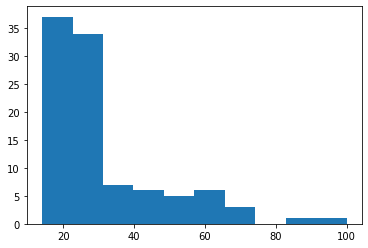

In [82]:
plt.hist(turn_nums)
plt.show()

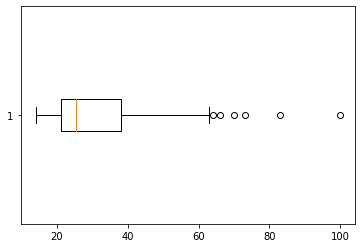

In [83]:
plt.boxplot(turn_nums, vert=False)
plt.show()

(array([22.,  0.,  0.,  0.,  0.,  0., 22.,  0.,  0., 56.]),
 array([-1. , -0.7, -0.4, -0.1,  0.2,  0.5,  0.8,  1.1,  1.4,  1.7,  2. ]),
 <a list of 10 Patch objects>)

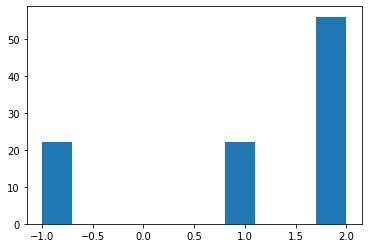

In [84]:
plt.hist(game_conclusions)

# Our agent against random AI (Our agent plays as upper)

In [88]:
# Record how long each game goes for
turn_nums = []

# Record conclusion of game
game_conclusions = []

for i in range(100):

    # Do this at the start of each match

    coord_dict, piece_dict = getEmptyBoardConfigs()

    upper_thrown_num = 0
    lower_thrown_num = 0

    turn_num = 1

    last_upper_move = None
    last_lower_move = None


    while not gameEnded(piece_dict, upper_thrown_num, lower_thrown_num, turn_num):

        # Do this all each turn:

        upper_root = State_node(team="upper", coord_dict=coord_dict, piece_dict=piece_dict, 
                          upper_thrown_num=upper_thrown_num, lower_thrown_num=lower_thrown_num, 
                          primary_move_list=[], parent_secondary_node=None, node_depth=0)
        
        lower_root = State_node(team="lower", coord_dict=coord_dict, piece_dict=piece_dict, 
                          upper_thrown_num=upper_thrown_num, lower_thrown_num=lower_thrown_num, 
                          primary_move_list=[], parent_secondary_node=None, node_depth=0)

        
        if turn_num <= 4:
            upper_move = starting_move_generator_smart("upper", last_lower_move, turn_num)
        else:

            # Build upper's tree
            buildStateTree(upper_root, desired_depth=2, pruning_function=test_pruning_three, turn_num=turn_num)


            # Calculate scores for upper's moves
            calculateMoveScores(upper_root, heuristic_function=test_board_heuristic_three)

            # Upper's chosen move
            upper_move = getBestMove(upper_root)

            
            
        # Lower's chosen move
        all_lower_moves = getPossibleMoves(lower_root, "lower")
        all_lower_moves_len = len(all_lower_moves)
        rand_index = random.randint(0, all_lower_moves_len-1)

        lower_move = all_lower_moves[rand_index]
            
        last_upper_move = upper_move
        last_lower_move = lower_move

        # Update board representations

        coord_dict, piece_dict, upper_thrown_num, lower_thrown_num = resolveMoves(
            upper_move, lower_move, coord_dict, upper_thrown_num, lower_thrown_num)


        turn_num += 1

    game_conclusion = gameEnded(piece_dict, upper_thrown_num, lower_thrown_num, turn_num, debug=False)

    turn_nums.append(turn_num)

    # Record conclusion of game
    game_conclusions.append(game_conclusion)

    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


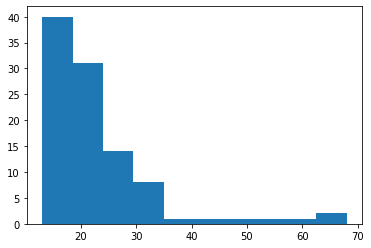

In [89]:
plt.hist(turn_nums)
plt.show()

In [92]:
from collections import Counter

yee = Counter(game_conclusions)

In [93]:
yee

Counter({1: 98, 2: 2})

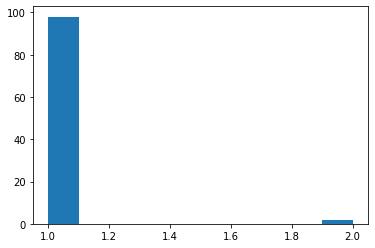

In [90]:
plt.hist(game_conclusions)
plt.show()

UPPER_WINS = 1\
LOWER_WINS = -1\
DRAW = 2\
NOT_ENDED = 0